In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import os

Define simple histogram matching function

In [2]:
def hist_matching(data_in, cdf_in, bins_in, cdf_out, bins_out):

    bins_in = 0.5*(bins_in[:-1] + bins_in[1:]) # Points for interpolation (input bins contain the edges)
    bins_out = 0.5*(bins_out[:-1] + bins_out[1:])
    cdf_tmp = np.interp(data_in.flatten(), bins_in.flatten(), cdf_in.flatten())  # Interpolation
    data_out = np.interp(cdf_tmp, cdf_out.flatten(), bins_out.flatten())

    return data_out

#### HMI

Synthetic data

In [5]:
# Input files (simulation)
synthdir='/mnt/c/Users/Lea/OneDrive/SolarML_2023/HistMatch_testdata/ic_synthetic/'
filenames_synth = os.listdir(synthdir) # sorted(glob.glob('../HistMatch_testdata/HMI_synthetic_192km/ic*'))
print(filenames_synth) 

# Dimensions
n_synth_frames = len(filenames_synth) # N test samples
border_x1 = 5 # N pixels to remove from each border of the input data
border_x2 = 5  
border_y1 = 5
border_y2 = 5  
nx = np.shape(synth0)[1] - border_x1 - border_x2 # Image dimensions
ny = np.shape(synth0)[0] - border_y1 - border_y2

# Reference fields
synth_data = np.zeros((n_synth_frames, ny, nx))
for i in range(n_synth_frames):
    synth_data[i, :, :] = fits.open(synthdir+filenames_synth[i])[0].data[border_y1:border_y1+ny, border_x1:border_x1+nx] # read_fits(filenames_test_ic[i])[border_y1:border_y1+ny, border_x1:border_x1+nx]
print(np.shape(synth_data))

['ic_200.fits', 'ic_212.fits', 'ic_224.fits', 'ic_236.fits', 'ic_248.fits']
(5, 246, 502)


In [6]:
# Compute data properties
synth_mean = np.nanmean(synth_data)
synth_stddev = np.nanstd(synth_data)
synth_median = np.nanmedian(synth_data)

# Normalize/standardize data (your choice)
synth_data = (synth_data-synth_mean)/synth_stddev

# Bins for histograms (of the normalized quantities)
n_synth_bins = 2000
synth_bins = np.linspace(np.nanmin(synth_data), np.nanmax(synth_data), n_synth_bins)
width_synth_bins = synth_bins[1]-synth_bins[0]

# Compute histograms
synth_hist = np.zeros((n_synth_frames, n_synth_bins-1))
for i in range(n_synth_frames):
    synth_hist[i, :], _ = np.histogram(synth_data[i, :, :][np.isfinite(synth_data[i, :, :])].flatten(), 
                                         bins=synth_bins, 
                                         density=True)

# Cumulative histogram
synth_cdf = np.cumsum(np.nanmean(synth_hist*width_synth_bins, axis=0))

Real data

In [7]:
# Input files (observations)
obsdir='/mnt/c/Users/Lea/OneDrive/SolarML_2023/HistMatch_testdata/ic_hmi/'
filenames_obs = os.listdir(obsdir) # WHY THE IDX [60:460]?? sorted(glob.glob('../HistMatch_testdata/HMI_set/*continuum_nolimbdark.fits.gz'))[360:460]
print(filenames_obs)

# Dimensions
n_synth_frames = len(filenames_synth) # N test samples
border_x1 = 5 # N pixels to remove from each border of the input data
border_x2 = 5  
border_y1 = 5
border_y2 = 5  
nx = np.shape(synth0)[1] - border_x1 - border_x2 # Image dimensions
ny = np.shape(synth0)[0] - border_y1 - border_y2

# Reference fields
obs_data = np.zeros((n_obs_frames, ny, nx))
for i in range(n_obs_frames):
    obs_data[i, :, :] = fits.open(obsdir+filenames_obs[i])[0].data[border_y1:border_y1+ny, border_x1:border_x1+nx] # u.read_fits(filenames_test_ic[i])[border_y1:border_y1+ny, border_x1:border_x1+nx]
print(np.shape(obs_data))

['hmi.sharp_cea_720s.377.20110214_140000_TAI.continuum_nolimbdark.fits.gz', 'hmi.sharp_cea_720s.377.20110214_141200_TAI.continuum_nolimbdark.fits.gz', 'hmi.sharp_cea_720s.377.20110214_142400_TAI.continuum_nolimbdark.fits.gz', 'hmi.sharp_cea_720s.377.20110214_143600_TAI.continuum_nolimbdark.fits.gz', 'hmi.sharp_cea_720s.377.20110214_144800_TAI.continuum_nolimbdark.fits.gz']
(5, 367, 734)


In [8]:
# Compute data properties
obs_data_mean = np.nanmean(obs_data)
obs_data_stddev = np.nanstd(obs_data)
obs_data_median = np.nanmedian(obs_data)

# Normalize data
obs_data = (obs_data-obs_data_mean)/obs_data_stddev

# Bins for histograms (of the normalized quantities)
nb_bins = 2000
obs_bins = np.linspace(np.nanmin(obs_data), np.nanmax(obs_data), 
                        nb_bins)
width_obs_bins = obs_bins[1]-obs_bins[0]

# Compute histograms
obs_hist = np.zeros((n_obs_frames, nb_bins-1))
for i in range(n_obs_frames):
    obs_hist[i, :], _ = np.histogram(obs_data[i, :, :][np.isfinite(obs_data[i, :, :])].flatten(), 
                                      bins=obs_bins,
                                      density=True)

# Cumulative histogram
obs_cdf = np.cumsum(np.nanmean(obs_hist*width_obs_bins, axis=0))

Histogram matching 

In [9]:
# Matching sharp to muram2019 (single frame)
w_finite = np.isfinite(obs_data[0, :, :])
obs_data_match = hist_matching(obs_data[0, :, :][w_finite], obs_cdf, obs_bins, synth_cdf, synth_bins)
nx, ny = obs_data[0, :, :].shape
obs_data_matched = np.zeros((nx, ny))
obs_data_matched[w_finite] = obs_data_match


In [10]:
# Matching sharp to muram2019 (sequence)
data = obs_data[np.isfinite(obs_data)]
obs_data_matched = hist_matching(data.flatten(), obs_cdf, obs_bins, synth_cdf, synth_bins)

Plot CDFs

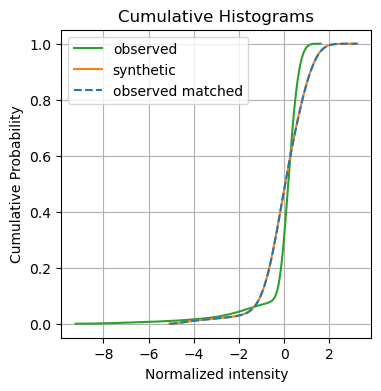

In [11]:
# CDF of matched image
nb_bins = 2000

obs_matched_bins = np.linspace(np.nanmin(obs_data_matched), np.nanmax(obs_data_matched), nb_bins)
width_obs_matched_bins =obs_matched_bins[1]-obs_matched_bins[0]
obs_matched_hist, _ = np.histogram(obs_data_matched.flatten(), bins=obs_matched_bins, density=True)
obs_matched_cdf = np.cumsum(obs_matched_hist*width_obs_matched_bins)

# Plot cumulative histograms
ncols = 1
nrows = 1
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(4,4))
x = (obs_bins[:-1] + obs_bins[1:]) / 2
ax.plot(x, obs_cdf, c=colors[2], label='observed')
x = (synth_bins[:-1] + synth_bins[1:]) / 2
ax.plot(x, synth_cdf, c=colors[1], label='synthetic')
x = (obs_matched_bins[:-1] + obs_matched_bins[1:]) / 2
ax.plot(x, obs_matched_cdf, linestyle="dashed", c=colors[0], label='observed matched')
ax.grid(True)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('Normalized intensity')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()
filename_output = 'plot.png'
plt.savefig(filename_output, format='png', dpi=300)
# plt.close('all')

# # Display
# Image(filename = filename_output, width=900)

#### DKIST

In [ ]:
import numpy as np
from astropy.io import fits
import scipy.signal
import matplotlib.pyplot as plt
from astropy.io import fits
import os

# Read in "good" images (well, image)
synthdir = '../Data/'
filenames_synth = ['DKIST_example.fits']
print('Images to match to: ', filenames_synth)
n_synth_frames = len(filenames_synth)

# Store good images as one 3D array
nx = np.shape(fits.open(synthdir+filenames_synth[0])[0].data)[1]
ny = np.shape(fits.open(synthdir+filenames_synth[0])[0].data)[0]
synth_data = np.zeros((n_synth_frames, ny, nx))
for i in range(n_synth_frames):
    synth_data[i, :, :] = fits.open(synthdir+filenames_synth[i])[0].data

# Normalize good images
synth_mean = np.nanmean(synth_data)
synth_stddev = np.nanstd(synth_data)
synth_data = (synth_data-synth_mean)/synth_stddev

# Compute good image histograms
n_synth_bins = 2000
synth_bins = np.linspace(np.nanmin(synth_data), np.nanmax(synth_data), n_synth_bins)
width_synth_bins = synth_bins[1]-synth_bins[0]
synth_hist = np.zeros((n_synth_frames, n_synth_bins-1))
for i in range(n_synth_frames):
    synth_hist[i, :], _ = np.histogram(synth_data[i, :, :][np.isfinite(synth_data[i, :, :])].flatten(), 
                                       bins=synth_bins, density=True)

# Compute good image CDF
print(synth_hist.shape)
print(width_synth_bins); a=b
synth_cdf = np.cumsum(np.nanmean(synth_hist*width_synth_bins, axis=0))

# Read in "bad" images
obsdir = '../Data/DKIST_gband_series_183653/'
filenames_obs =  [filename for filename in os.listdir(obsdir) if '4096' in filename and not 'SEG' in filename]
print('Images to scale: ', filenames_obs)
n_obs_frames = len(filenames_obs)

# Store bad images as one 3D array
border = 20
nx = np.shape(fits.open(obsdir+filenames_obs[0])[1].data)[1] - 2*border
ny = np.shape(fits.open(obsdir+filenames_obs[0])[1].data)[0] - 2*border
obs_data = np.zeros((n_obs_frames, ny, nx))
for i in range(n_obs_frames):
    obs_data[i, :, :] = fits.open(obsdir+filenames_obs[i])[1].data[border:border+ny, border:border+nx]

# Normalize bad images
obs_data_mean = np.nanmean(obs_data)
obs_data_stddev = np.nanstd(obs_data)
obs_data = (obs_data-obs_data_mean)/obs_data_stddev

# Compute bad image histograms
nb_bins = 2000
obs_bins = np.linspace(np.nanmin(obs_data), np.nanmax(obs_data), nb_bins)
width_obs_bins = obs_bins[1]-obs_bins[0]
obs_hist = np.zeros((n_obs_frames, nb_bins-1))
for i in range(n_obs_frames):
    obs_hist[i, :], _ = np.histogram(obs_data[i, :, :][np.isfinite(obs_data[i, :, :])].flatten(), 
                                     bins=obs_bins, density=True)

# Compute bad image CDF
obs_cdf = np.cumsum(np.nanmean(obs_hist*width_obs_bins, axis=0))

# Match one frame of obs to one frame of synth
obs_data_matched = hist_matching(obs_data[0, :, :], obs_cdf, obs_bins, synth_cdf, synth_bins)
obs_data_matched = obs_data_matched.reshape(np.shape(obs_data[0, :, :]))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(obs_data[0, :, :])
ax1.set_title('original image')
ax2.imshow(obs_data_matched)
ax2.set_title('scaled image')

# Match all obs to all synth
data = obs_data
obs_data_matched = hist_matching(data, obs_cdf, obs_bins, synth_cdf, synth_bins)
obs_data_matched = obs_data_matched.reshape(np.shape(obs_data))
fig, axs = plt.subplots(10, 2, figsize=(15, 50))
j = 0
for i in range(0, 19, 2):
    axs[0,i].imshow(obs_data[j, :, :])
    axs[0,i].set_title('original image')
    axs[1,i].imshow(obs_data_matched[j, :, :])
    axs[1,i].set_title('scaled image')
    j = j+1

# Compute CDF of matched image
nb_bins = 2000
obs_matched_bins = np.linspace(np.nanmin(obs_data_matched), np.nanmax(obs_data_matched), nb_bins)
width_obs_matched_bins =obs_matched_bins[1]-obs_matched_bins[0]
obs_matched_hist, _ = np.histogram(obs_data_matched.flatten(), bins=obs_matched_bins, density=True)
obs_matched_cdf = np.cumsum(obs_matched_hist*width_obs_matched_bins)

# Plot cumulative histograms
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(4,4))
x = (obs_bins[:-1] + obs_bins[1:]) / 2
ax.plot(x, obs_cdf, c=colors[2], label='observed')
x = (synth_bins[:-1] + synth_bins[1:]) / 2
ax.plot(x, synth_cdf, c=colors[1], label='synthetic')
x = (obs_matched_bins[:-1] + obs_matched_bins[1:]) / 2
ax.plot(x, obs_matched_cdf, linestyle="dashed", c=colors[0], label='observed matched')
ax.grid(True)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('Normalized intensity')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()
filename_output = 'plot.png'
plt.savefig(filename_output, format='png', dpi=300)